## Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import random

torch.manual_seed(0); random.seed(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


## Data

choose one of the two cells for the data generation process

### Synthetic Datast - Easy

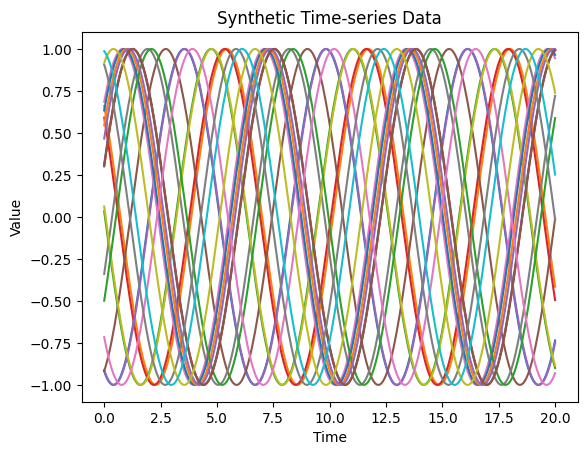

In [ ]:
time_steps = 300 # value over 300 time steps
num_nodes = 20 # number of stocks
t = np.linspace(0, 20, time_steps)

data = np.array([np.sin(t + np.random.uniform(0, 2*np.pi)) for _ in range(num_nodes)])

plt.plot(t, data.T)
plt.title("Synthetic Time-series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

### Synthetic Dataset - Complex

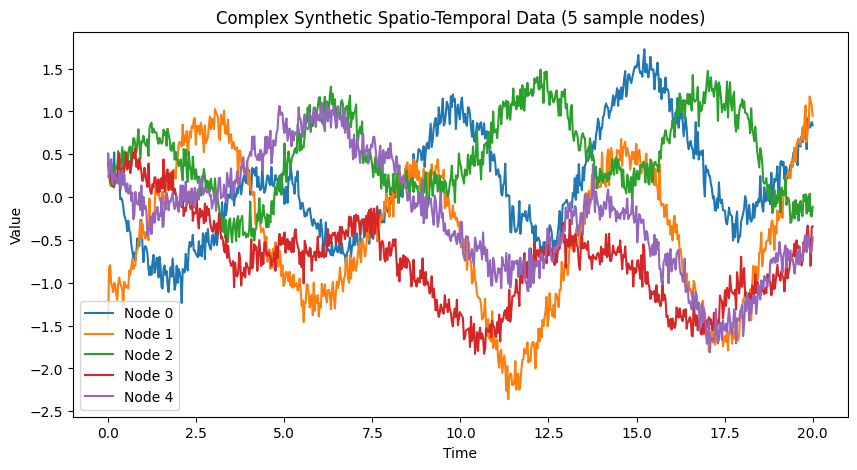

In [ ]:
# parameters
time_steps = 700
num_nodes  = 20
t = np.linspace(0, 20, time_steps)

# base signals: sine waves with random amplitude, frequency, and phase
amps = np.random.uniform(0.5, 1.5, size=num_nodes)
freqs = np.random.uniform(0.8, 1.2, size=num_nodes)
phases = np.random.uniform(0, 2*np.pi, size=num_nodes)
base = np.array([amps[i] * np.sin(freqs[i] * t + phases[i])
                 for i in range(num_nodes)])

# random walk component to add non-stationarity
rw = np.cumsum(0.05 * np.random.randn(num_nodes, time_steps), axis=1)

# regime shifts: abrupt jumps or trend changes at t = 150
regime = np.zeros((num_nodes, time_steps))
for i in range(num_nodes):
    jump = np.random.uniform(-2, 2)
    regime[i, t > 150] = jump

# build a simple adjacency for coupling (e.g., Erdős–Rényi)
p = 0.2
adj = (np.random.rand(num_nodes, num_nodes) < p).astype(float)
np.fill_diagonal(adj, 0)

# normalize adjacency row-wise
deg = adj.sum(axis=1, keepdims=True) + 1e-6
adj_norm = adj / deg

# generate coupled spatio-temporal data
alpha = 0.3
noise_level = 0.1
data = np.zeros((num_nodes, time_steps))
# init
data[:, 0] = base[:, 0] + rw[:, 0] + regime[:, 0]

# sample
for tt in range(1, time_steps):
    neighbor_term = adj_norm @ data[:, tt-1]
    data[:, tt] = (alpha * neighbor_term +
                   (1-alpha) * (base[:, tt] + rw[:, tt] + regime[:, tt]) +
                   noise_level * np.random.randn(num_nodes))

# plot example for viewing
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(t, data[i], label=f'Node {i}')
plt.title("Complex Synthetic Spatio-Temporal Data (5 sample nodes)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Graph Structure

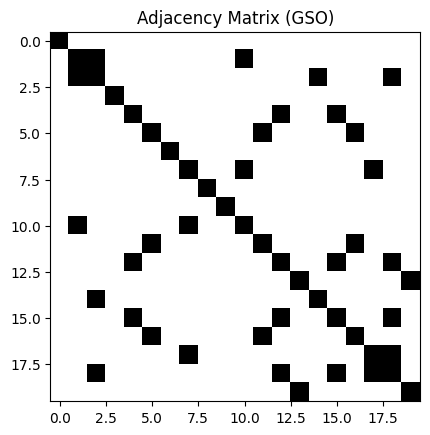

In [ ]:
corr_matrix = np.corrcoef(data)
threshold = 0.7 # can play on that for sparsity
adj_matrix = (np.abs(corr_matrix) > threshold).astype(float)

# Visualize adjacency
plt.imshow(adj_matrix, cmap='Greys')
plt.title("Adjacency Matrix (GSO)")
plt.show()

## Graph Filter

### 1-hop Filter

This is a graph filter under the form of a function and you can **uncomment** to use it or...

In [ ]:
# def simple_graph_filter(x, A):
#     # x: [batch, nodes], A: adjacency [nodes, nodes]
#     # Graph convolution: A * x.T, then take care of degrees.
#     # We need A to have shape [nodes, nodes] and x.T to have shape [nodes, batch]
#     # Result of matmul will be [nodes, batch]
#     # Then we transpose back to [batch, nodes]

#     # Ensure A is a torch tensor
#     if not isinstance(A, torch.Tensor):
#         A = torch.tensor(A, dtype=torch.float32)

#     # Calculate degree from the adjacency matrix A
#     # Keep dim to maintain the correct shape for broadcasting
#     degree = torch.sum(A, dim=1, keepdim=True) + 1e-6

#     # Apply graph filter. We transpose x to align node dimension for multiplication with A.
#     # A shape: [nodes, nodes]
#     # x.T shape: [nodes, batch]
#     # torch.matmul(A, x.T) shape: [nodes, batch]
#     # Transpose the result back to [batch, nodes]
#     # The degree is [nodes, 1], which will broadcast correctly with the [nodes, batch] result of matmul before division.
#     filtered = torch.matmul(A, x.T).T / degree

#     return filtered

... you can use the nn.module class type to make it more compatible with pytorch style.

In [ ]:
# Graph filter class module for pytorch
class GraphFilter(nn.Module):
    def __init__(self, GSO):
        super().__init__()
        self.register_buffer('GSO', torch.tensor(GSO, dtype=torch.float32))
        deg = torch.sum(self.GSO, dim=1, keepdim=True) + 1e-6    # [N,1]
        self.register_buffer('inv_degree', (1.0/deg).t())       # [1,N]

    def forward(self, x):
        # x: [batch*seq, N]
        out = x @ self.GSO         # [batch*seq, N]
        return out * self.inv_degree  # normalize

### K-hop filter (polynomial)

In [ ]:
class PolynomialGraphFilter(nn.Module):
    """
    Implements y = sum_{k=0}^K theta[k] * (x @ S^k), optionally normalized.
    """
    def __init__(self, GSO, K, normalize=True):
        super().__init__()
        N = GSO.shape[0]
        self.K = K
        self.normalize = normalize

        # register GSO and precompute its powers S^0 ... S^K
        S = torch.tensor(GSO, dtype=torch.float32)
        self.register_buffer('powers', torch.stack(
            [torch.linalg.matrix_power(S, k) for k in range(K+1)], dim=0))  # shape [K+1, N, N]

        # learnable coefficients for each hop (could also be fixed)
        self.theta = nn.Parameter(torch.ones(K+1) / (K+1))

        if normalize:
            # precompute degrees of the 1-hop GSO for normalization
            deg = torch.sum(S, dim=1, keepdim=True) + 1e-6  # [N,1]
            inv_deg = (1.0 / deg).t()                       # [1,N]
            self.register_buffer('inv_degree', inv_deg)

    def forward(self, x):
        """
        x: Tensor of shape [batch*seq, N]
        returns: Tensor of shape [batch*seq, N]
        """
        # accumulate contributions from each hop
        out = 0
        for k in range(self.K+1):
            # x @ S^k shape [batch*seq, N]
            hop_feat = x @ self.powers[k]
            # weight it
            out = out + self.theta[k] * hop_feat

        if self.normalize:
            # normalize by degree of 1-hop GSO
            out = out * self.inv_degree

        return out


## Model

### Baseline LSTM

In [ ]:
# Baseline LSTM model without graph filtering
class Baseline_LSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super().__init__()
        # Input feature size for LSTM is directly num_nodes
        self.lstm = nn.LSTM(num_nodes, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        # x shape: [batch, seq, nodes]
        # Pass x directly to LSTM
        out, _ = self.lstm(x)

        # out shape: [batch, seq, hidden_dim]
        # Take output from the last time step
        pred = self.fc(out[:, -1, :])

        # pred shape: [batch, num_nodes]
        return pred

### GraphLSTM *Hybrid*

This is an implementation of graph LSTM in its hybrid form - which means that first we apply the filter to the signal then the LSTM to the signal. In this case we use a simple graph filter which aggregates information from 1-hop neightbor.

In [ ]:
class Graph_LSTM(nn.Module):
    """
    Graph-LSTM: applies a GraphFilter per time step, then feeds into an LSTM.
    Fully vectorized over the time dimension for speed.
    """
    def __init__(self, num_nodes, hidden_dim, GSO):
        super().__init__()
        self.filter = GraphFilter(GSO)
        self.lstm   = nn.LSTM(num_nodes, hidden_dim, batch_first=True)
        self.fc     = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        """
        x: [batch, seq, nodes]
        returns: [batch, nodes] (prediction for next step)
        """
        batch, seq, nodes = x.shape

        # flatten batch & seq, apply graph filter in one go
        x_flat = x.view(batch * seq, nodes)         # [B*S, N]
        x_filt = self.filter(x_flat)                # [B*S, N]

        # reshape back into sequence
        x_seq  = x_filt.view(batch, seq, nodes)     # [B, S, N]

        # run through LSTM and predict from last hidden
        out, _ = self.lstm(x_seq)                   # out: [B, S, H]
        last   = out[:, -1, :]                      # [B, H]
        return self.fc(last)                        # [B, N]

### Graph LSTM Parametrized

This an implementation of Graph LSTM which is *parametrized*, which means that we substitue the weight matrices of the LSTM **gates with graph filters.** Also, in this case, we are using a 1-hop filter.

In [ ]:
class GraphLSTMCell(nn.Module):
    """
    LSTM cell where input-to-gate and hidden-to-gate transforms
    are polynomial graph filters of order K on graph shift operator GSO.
    Replaces dense W_x and W_h with Graph Shift Operator powers.

    [TO DO IN FUTURE: Replace this with the class polynomial shift operator that i wrote]
    """

    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        N = GSO.shape[0]
        self.hidden_size = hidden_size
        self.K = K

        # register the shift operator and its powers as buffers
        GSO_tensor = torch.tensor(GSO, dtype=torch.float32)
        self.register_buffer('GSO', GSO_tensor)
        powers = [torch.matrix_power(GSO_tensor, k) for k in range(K+1)]
        self.register_buffer('powers', torch.stack(powers, dim=0))  # [K+1, N, N]

        # rraph filter coefficients for input and hidden, for all 4 gates
        # rhape: [4 gates, K+1 coefficients]
        self.theta_x = nn.Parameter(torch.zeros(4, K+1))
        self.theta_h = nn.Parameter(torch.zeros(4, K+1))
        # rate biases (4 * hidden_size)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.theta_x, -0.1, 0.1)
        nn.init.uniform_(self.theta_h, -0.1, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x: [batch, N] node features at time t
        hx: (h, c) each [batch, hidden_size]
        returns: (h_next, c_next)
        """
        h, c = hx
        B, N = x.shape
        H = self.hidden_size
        # ensuring hidden_size matches number of nodes for pure graph filtering
        assert H == N, "hidden_size must equal num_nodes for GraphLSTM"

        # eompute GSO^k x and GSO^k h: shapes [K+1, batch, N]
        #    using einsum: powers[k] @ x^T (N,N) @ (N,B) (N,B)
        filtered_x = torch.einsum('kij,bj->kb i', self.powers, x)
        filtered_h = torch.einsum('kij,bj->kb i', self.powers, h)

        # weight and sum over k for each of the 4 gates
        #    gates_x: [4, batch, N], gates_h: [4, batch, N]
        gates_x = torch.einsum('ik,kbj->ibj', self.theta_x, filtered_x)
        gates_h = torch.einsum('ik,kbj->ibj', self.theta_h, filtered_h)

        # sum, add bias, reshape to [batch, 4*N]
        gates = gates_x + gates_h        # [4, B, N]
        gates = gates.permute(1, 0, 2)    # [B, 4, N]
        gates = gates.reshape(B, 4 * N)   # [B, 4*N]
        gates = gates + self.bias        # broadcast bias

        # split into the four gates
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        # LSTM cell update
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class GraphLSTM(nn.Module):
    """
    Sequence model using the GraphLSTMCell.
    """
    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        self.cell = GraphLSTMCell(GSO, hidden_size, K)
        self.hidden_size = hidden_size

    def forward(self, x, hx=None):
        """
        x: [batch, seq, nodes]
        hx: optional initial (h0, c0), each [batch, hidden_size]
        returns: (out_seq, (h_n, c_n))
        """
        B, GSO_len, N = x.shape
        if hx is None:
            h = x.new_zeros(B, self.hidden_size)
            c = x.new_zeros(B, self.hidden_size)
        else:
            h, c = hx

        outputs = []

        for t in range(GSO_len):
            h, c = self.cell(x[:, t, :], (h, c))
            outputs.append(h.unsqueeze(1))
        out_seq = torch.cat(outputs, dim=1)  # [B, S_len, N]
        return out_seq, (h, c)


class Graph_LSTM_Parametrized(nn.Module):
    """
    GraphLSTM-based next-step predictor.
    """
    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        self.glstm = GraphLSTM(GSO, hidden_size, K)
        # Final readout: map hidden_size (== nodes) back to node predictions
        self.fc = nn.Linear(hidden_size, GSO.shape[0])

    def forward(self, x):
        """
        x: [batch, seq, nodes]
        returns: [batch, nodes]  next-step prediction
        """
        out_seq, _ = self.glstm(x)       # [B, seq, N]
        last = out_seq[:, -1, :]         # [B, N]
        return self.fc(last)             # [B, N]

### Graph xLSTM *Hybrid*

This is an implementation of graph xLSTM in an *hybrid* version, which means tha first we apply a graph convolution over the signal and then xLSTM over the output of the graph convolution.

In [ ]:
# a single xLSTM cell with low-rank weight factorization
class xLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, rank):
        super().__init__()
        self.input_size, self.hidden_size, self.rank = input_size, hidden_size, rank
        # input-to-gate factors
        self.Wxu = nn.Parameter(torch.Tensor(input_size, rank))
        self.Wxv = nn.Parameter(torch.Tensor(rank, 4 * hidden_size))
        # hidden-to-gate factors
        self.Whu = nn.Parameter(torch.Tensor(hidden_size, rank))
        self.Whv = nn.Parameter(torch.Tensor(rank, 4 * hidden_size))
        # gate biases
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        # xavier init for factors
        nn.init.xavier_uniform_(self.Wxu)
        nn.init.xavier_uniform_(self.Wxv)
        nn.init.xavier_uniform_(self.Whu)
        nn.init.xavier_uniform_(self.Whv)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x: [batch, input_size]
        hx: tuple(h, c), each [batch, hidden_size]
        returns: (h_next, c_next)
        """
        h, c = hx
        # kow-rank multiplication: x @ (Wxu @ Wxv)
        x_proj = x @ self.Wxu @ self.Wxv      # [batch, 4H]
        h_proj = h @ self.Whu @ self.Whv      # [batch, 4H]
        gates = x_proj + h_proj + self.bias   # [batch, 4H]
        i, f, g, o = gates.chunk(4, dim=1)    # each [batch, H]
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


# single-layer xLSTM
class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, rank):
        super().__init__()
        self.cell = xLSTMCell(input_size, hidden_size, rank)
        self.hidden_size = hidden_size

    def forward(self, x, hx=None):
        """
        x: [batch, seq, input_size]
        hx: optional (h0, c0), each [batch, hidden_size]
        returns: (output_seq, (h_n, c_n))
          output_seq: [batch, seq, hidden_size]
        """
        B, S, _ = x.size()
        if hx is None:
            h = x.new_zeros(B, self.hidden_size)
            c = x.new_zeros(B, self.hidden_size)
        else:
            h, c = hx

        outputs = []
        for t in range(S):
            h, c = self.cell(x[:, t, :], (h, c))
            outputs.append(h.unsqueeze(1))
        out_seq = torch.cat(outputs, dim=1)
        return out_seq, (h, c)


# combine GraphFilter + xLSTM + final projection
class Graph_xLSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim, rank, A):
        super().__init__()
        self.filter = GraphFilter(A)
        self.xlstm  = xLSTM(input_size=num_nodes,
                            hidden_size=hidden_dim,
                            rank=rank)
        self.fc     = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        """
        x: [batch, seq, num_nodes]
        returns: [batch, num_nodes]  (prediction for next step)
        """
        B, S, N = x.shape
        # vectorize spatial filtering
        x_flat = x.view(B * S, N)           # [B⋅S, N]
        x_filt = self.filter(x_flat)        # [B⋅S, N]
        x_seq  = x_filt.view(B, S, N)       # [B, S, N]

        # temporal xLSTM
        out_seq, _ = self.xlstm(x_seq)      # out_seq: [B, S, H]
        last      = out_seq[:, -1, :]       # [B, H]

        # project to per-node output
        return self.fc(last)                # [B, N]

### Graph xLSTM Parametrized

In [ ]:
class Graph_xLSTMCell(nn.Module):
    """
    xLSTM cell where each gate’s input‐to‐gate and hidden‐to‐gate transforms
    are K‐hop polynomial graph filters on GSO instead of low‐rank matrices.
    """
    def __init__(self, GSO, hidden_size, K=2):
        """
        GSO:         numpy or torch [N, N] adjacency (or normalized adjacency)
        hidden_size: must equal N (so h, c ∈ R^N)
        K:           number of hops (filter order)
        """
        super().__init__()
        N = GSO.shape[0]
        self.hidden_size = hidden_size
        self.K = K
        assert hidden_size == N, "hidden_size must equal num_nodes"

        # register the adjacency as a buffer and precompute powers S^0..S^K
        S = torch.tensor(GSO, dtype=torch.float32)
        powers = [torch.matrix_power(S, k) for k in range(K+1)]
        self.register_buffer('powers', torch.stack(powers, dim=0))  # shape [K+1, N, N]

        # learnable filter coefficients
        #    theta_x[i,k] is coefficient for gate i, hop k on the input x
        #    theta_h[i,k] is coefficient for gate i, hop k on the hidden h
        self.theta_x = nn.Parameter(torch.zeros(4, K+1))  # [4, K+1]
        self.theta_h = nn.Parameter(torch.zeros(4, K+1))  # [4, K+1]

        # standard LSTM bias vector of length 4N
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        # initialize filter coefficients uniformly in [−0.1, 0.1], biases to zero
        nn.init.uniform_(self.theta_x, -0.1, 0.1)
        nn.init.uniform_(self.theta_h, -0.1, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x:  tensor [B, N]        (current input for all N nodes)
        hx: (h, c) each [B, N]   (previous hidden & cell states)
        returns: (h_next, c_next), each [B, N]
        """
        h, c = hx
        B, N = x.shape
        H = self.hidden_size

        # compute filtered versions for x and h: shapes [K+1, B, N]
        #    ssing: filtered_x[k] = x @ (S^k), filtered_h[k] = h @ (S^k)
        filtered_x = torch.stack([x @ self.powers[k] for k in range(self.K+1)], dim=0)  # [K+1, B, N]
        filtered_h = torch.stack([h @ self.powers[k] for k in range(self.K+1)], dim=0)  # [K+1, B, N]

        # weight & sum each hop for each gate: result ∈ [4, B, N]
        #    gates_x[i] = Σ_k theta_x[i,k] * filtered_x[k]
        #    gates_h[i] = Σ_k theta_h[i,k] * filtered_h[k]
        gates_x = torch.einsum('ik,kbn->ibn', self.theta_x, filtered_x)  # [4, B, N]
        gates_h = torch.einsum('ik,kbn->ibn', self.theta_h, filtered_h)  # [4, B, N]

        # combine, add bias, and reshape to [B, 4N]
        #    (gates_x + gates_h) has shape [4, B, N];
        #    permute to [B, 4, N], then reshape to [B, 4N], add bias.
        gates = (gates_x + gates_h).permute(1, 0, 2).reshape(B, 4 * N) + self.bias

        # split into input, forget, cell, output gates—each [B, N]
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        # standard LSTM cell update
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class Graph_xLSTM_Param(nn.Module):
    """
    A single‐layer xLSTM whose gates are entirely parameterized by graph filters.
    The forward pass:
      1) For each time step, apply Graph_xLSTMCell
      2) Collect hidden states over the sequence
      3) Use the final hidden state to predict next‐step outputs via a linear layer
    """
    def __init__(self, GSO, hidden_size, K=2):
        """
        GSO:         [N, N] adjacency or normalized adjacency
        hidden_size: must equal N
        K:           filter order (number of hops)
        """
        super().__init__()
        N = GSO.shape[0]
        assert hidden_size == N, "hidden_size must equal number of nodes N"
        self.cell = Graph_xLSTMCell(GSO, hidden_size, K)
        self.hidden_size = hidden_size
        # final read‐out
        self.fc = nn.Linear(hidden_size, N)

    def forward(self, x, hx=None):
        """
        x:  [B, S, N]  input sequence of length S for all N nodes
        hx: optional initial (h0, c0), each [B, N]
        returns: preds [B, N]  (prediction for next time step)
        """
        B, S, N = x.shape
        # nitialize hidden/cell if not provided
        if hx is None:
            h = x.new_zeros(B, N)
            c = x.new_zeros(B, N)
        else:
            h, c = hx

        # nroll for S steps
        for t in range(S):
            h, c = self.cell(x[:, t, :], (h, c))

        # h is now the hidden state at last time step [B, N]
        return self.fc(h)  # [B, N]

## Training

### Instantiate the Models

#### Baseline LSTM

In [ ]:
hidden_dim = 32
num_nodes  = adj_matrix.shape[0]
baseline_model = Baseline_LSTM(num_nodes=num_nodes, hidden_dim=hidden_dim).to(device)

#### GraphLSTM hybrid

In [ ]:
num_nodes    = adj_matrix.shape[0]
hidden_dim   = 32 # adj_matrix.shape[0]

graph_lstm_hybrid = Graph_LSTM(num_nodes=num_nodes,
                    hidden_dim=hidden_dim,
                    GSO=adj_matrix).to(device)

#### GraphLSTM Parametrized

In [ ]:
num_nodes   = adj_matrix.shape[0] # train_x.shape[-1]  # number of nodes
hidden_size = num_nodes         # must equal num_nodes for GraphLSTM
K           = 2                 # polynomial order of graph filter

graph_lstm_param = Graph_LSTM_Parametrized(GSO=adj_matrix, hidden_size=hidden_size, K=K).to(device)

#### Graph xLSTM Hybrid

In [ ]:
num_nodes  = adj_matrix.shape[0]
hidden_dim = 32
rank       = 16   # low-rank size; you can tune between [8, hidden_dim]

graph_xlstm_hybrid = Graph_xLSTM(num_nodes=num_nodes,
                    hidden_dim=hidden_dim,
                    rank=rank,
                    A=adj_matrix).to(device)

#### Graph xLSTM Parametrized

In [ ]:
num_nodes  = adj_matrix.shape[0]
hidden_dim = 32
K = 2

graph_xlstm_param = Graph_xLSTM_Param(GSO=adj_matrix, hidden_size=num_nodes, K=K).to(device)

### Global Training

Count the nuneber of trainable parameters for each model

In [ ]:
models = {
    'Baseline LSTM': baseline_model,
    'Graph-LSTM Hybrid': graph_lstm_hybrid,
    'Graph-LSTM Parametrized': graph_lstm_param,
    'Graph-xLSTM Hybrid': graph_xlstm_hybrid,
    'Graph-xLSTM Parametrized': graph_xlstm_param
}

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

for name, model in models.items():
    total, trainable = count_parameters(model)
    print(f"{name}: Total params = {total:,}, Trainable params = {trainable:,}")

Baseline LSTM: Total params = 7,572, Trainable params = 7,572
Graph-LSTM Hybrid: Total params = 7,572, Trainable params = 7,572
Graph-LSTM Parametrized: Total params = 524, Trainable params = 524
Graph-xLSTM Hybrid: Total params = 5,716, Trainable params = 5,716
Graph-xLSTM Parametrized: Total params = 524, Trainable params = 524


#### With Data Loader

In [ ]:
# sliding-window Dataset for next-step forecasting ===
class TimeSeriesDataset(Dataset):
    def __init__(self, data_tensor, window_size):
        """
        data_tensor: Tensor of shape [1, T, N]
        window_size: int, number of past steps to use for each sample
        """
        # Squeeze to [T, N]
        self.data = data_tensor.squeeze(0)  # [T, N]
        self.window_size = window_size
        self.T, self.N = self.data.shape

        # Number of possible samples (windows)
        self.num_samples = self.T - window_size
        # The indices for the start of valid windows are from 0 to self.T - window_size - 1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Input: steps idx .. idx+window_size-1
        # Target: step idx+window_size
        # The maximum valid idx is self.T - window_size - 1
        # The target index is idx + window_size
        # Max target index = (self.T - window_size - 1) + window_size = self.T - 1
        x = self.data[idx : idx + self.window_size]     # [window_size, N]
        y = self.data[idx + self.window_size]            # [N]
        return x, y

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ensure data_torch is on device before creating the dataset subset indices
data_torch = torch.tensor(data.T, dtype=torch.float32).unsqueeze(0).to(device)

_, T, N = data_torch.shape
# define split points based on number of time steps
train_T = int(0.8 * T) # 80% for training data
val_T = int(0.1 * T)   # 10% for validation data
test_T = T - train_T - val_T # Remaining for test data

# define a window size (e.g., 20 time steps)
window_size = 20

# create the full dataset containing all possible windows
# rhis dataset can generate windows starting from index 0 up to T - window_size - 1
full_dataset = TimeSeriesDataset(data_torch.cpu(), window_size) # Create on CPU first

# calculate the number of samples (windows) for each split
# a window starting at index 'i' uses data from 'i' to 'i+window_size-1'
# and targets step 'i+window_size'.
# the latest possible target index is T-1.
# so the latest possible window start index is T - 1 - window_size.

# windows for training: Start indices from 0 up to (train_T - window_size - 1)
num_train_samples = train_T - window_size
# ensure num_train_samples is non-negative
num_train_samples = max(0, num_train_samples)

# windows for validation: Start indices from num_train_samples up to (num_train_samples + val_T - 1)
# note: This split uses the *number of samples* (windows), not time steps directly.
# the actual data points used by the validation windows are (train_T-window_size) to (train_T-window_size + val_T + window_size - 1)
num_val_samples = val_T
# Ensure num_val_samples is non-negative
num_val_samples = max(0, num_val_samples)

# windows for test: Start indices from num_train_samples + num_val_samples up to (T - window_size - 1)
num_test_samples = full_dataset.num_samples - num_train_samples - num_val_samples
# ensure num_test_samples is non-negative
num_test_samples = max(0, num_test_samples)


# alculate indices for train/val/test splits based on sample counts
train_indices = list(range(0, num_train_samples))
val_indices = list(range(num_train_samples, num_train_samples + num_val_samples))
test_indices = list(range(num_train_samples + num_val_samples, num_train_samples + num_val_samples + num_test_samples))

# subset the dataset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Total time steps: {T}")
print(f"Window size: {window_size}")
print(f"Total possible samples (windows): {full_dataset.num_samples}")
print(f"Train samples: {len(train_dataset)} (indices {0} to {len(train_dataset)-1})")
print(f"Val samples:   {len(val_dataset)} (indices {len(train_dataset)} to {len(train_dataset)+len(val_dataset)-1})")
print(f"Test samples:  {len(test_dataset)} (indices {len(train_dataset)+len(val_dataset)} to {len(train_dataset)+len(val_dataset)+len(test_dataset)-1})")

# train and evaluate with dataloader
def train_and_evaluate_dataloader(model, train_loader, val_loader, test_loader=None,
                                  epochs=30, lr=1e-2, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0.0
        for x_batch, y_batch in train_loader:
            # x_batch: [B, window_size, N], y_batch: [B, N]
            # Ensure data is on the correct device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            pred = model(x_batch)         # [B, N]
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                # Ensure data is on the correct device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = criterion(pred, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Logging
        if epoch==1 or epoch%5==0 or epoch==epochs:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {epoch_train_loss:.6f} | "
                  f"Val Loss:   {epoch_val_loss:.6f}")

    test_loss = None
    if test_loader is not None and len(test_loader.dataset) > 0:
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                # Ensure data is on the correct device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = criterion(pred, y_batch)
                running_test_loss += loss.item() * x_batch.size(0)
        test_loss = running_test_loss / len(test_loader.dataset)
        print(f"Test Loss: {test_loss:.6f}")
    elif test_loader is not None and len(test_loader.dataset) == 0:
        print("No test samples available for evaluation.")


    return {'train_losses': train_losses, 'val_losses': val_losses, 'test_loss': test_loss}

Total time steps: 700
Window size: 20
Total possible samples (windows): 680
Train samples: 540 (indices 0 to 539)
Val samples:   70 (indices 540 to 609)
Test samples:  70 (indices 610 to 679)


singular model training

Epoch 1/30 | Train Loss: 0.319424 | Val Loss:   0.293194
Epoch 5/30 | Train Loss: 0.023498 | Val Loss:   0.194211
Epoch 10/30 | Train Loss: 0.015952 | Val Loss:   0.172108
Epoch 15/30 | Train Loss: 0.013611 | Val Loss:   0.168418
Epoch 20/30 | Train Loss: 0.012819 | Val Loss:   0.158788
Epoch 25/30 | Train Loss: 0.012265 | Val Loss:   0.151184
Epoch 30/30 | Train Loss: 0.011968 | Val Loss:   0.128316
Test Loss: 0.175716
Train curve: [0.319423985210332, 0.09306081574071537, 0.04135174832560799, 0.028870514678684147, 0.023497561907226388, 0.01997353478588841, 0.017842087318951434, 0.01671426391059702, 0.015913402424617248, 0.01595152426849712, 0.015432082827795636, 0.014698800444602967, 0.014559615267948672, 0.013994959843429652, 0.013610819998112592, 0.013513128154657104, 0.013269360346550291, 0.013142507218501784, 0.013163963451304219, 0.01281882527876984, 0.013048370199447329, 0.012730400670658459, 0.012510111047462984, 0.012502303465523503, 0.01226509130475196, 0.012388907339085231, 

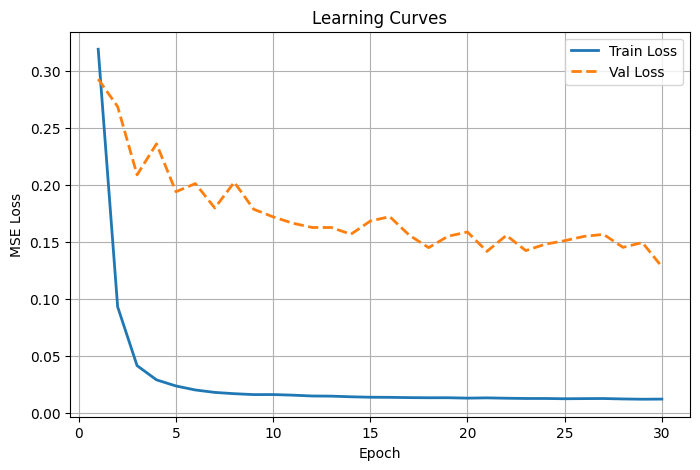

In [ ]:
# model = baseline_model
# model = graph_lstm_hybrid
# model = graph_lstm_param
model = graph_xlstm_hybrid

results = train_and_evaluate_dataloader(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=30,
    lr=1e-2,
    device=device
)

print("Train curve:", results['train_losses'])
print("Val curve:  ", results['val_losses'])
print("Test loss:  ", results['test_loss'])


epochs = range(1, len(results['train_losses']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, results['train_losses'], label='Train Loss', linewidth=2)
plt.plot(epochs, results['val_losses'],   '--', label='Val Loss',   linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

all models training


=== Training & Evaluating: Baseline LSTM ===
Epoch 1/30 | Train Loss: 0.190695 | Val Loss:   0.266093
Epoch 5/30 | Train Loss: 0.017604 | Val Loss:   0.189535
Epoch 10/30 | Train Loss: 0.016004 | Val Loss:   0.172993
Epoch 15/30 | Train Loss: 0.015706 | Val Loss:   0.174238
Epoch 20/30 | Train Loss: 0.015134 | Val Loss:   0.177633
Epoch 25/30 | Train Loss: 0.014972 | Val Loss:   0.164509
Epoch 30/30 | Train Loss: 0.014045 | Val Loss:   0.178490
Test Loss: 0.317213
Baseline LSTM Test Loss: 0.317213


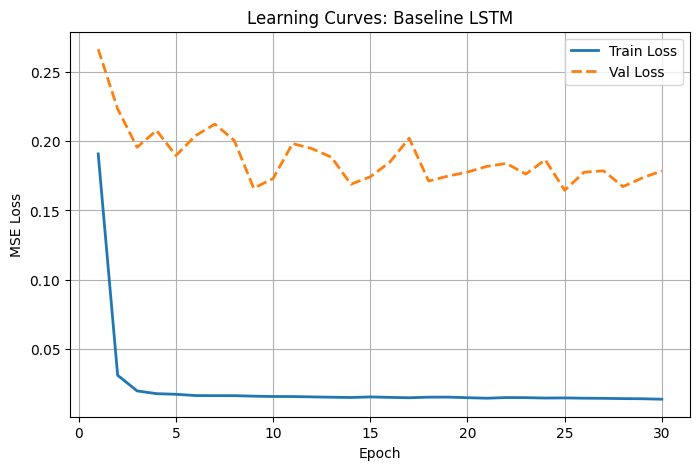


=== Training & Evaluating: Graph-LSTM Hybrid ===
Epoch 1/30 | Train Loss: 0.180668 | Val Loss:   0.305229
Epoch 5/30 | Train Loss: 0.018290 | Val Loss:   0.262948
Epoch 10/30 | Train Loss: 0.016988 | Val Loss:   0.273754
Epoch 15/30 | Train Loss: 0.016299 | Val Loss:   0.257717
Epoch 20/30 | Train Loss: 0.015569 | Val Loss:   0.253933
Epoch 25/30 | Train Loss: 0.015264 | Val Loss:   0.265333
Epoch 30/30 | Train Loss: 0.014845 | Val Loss:   0.251020
Test Loss: 0.623449
Graph-LSTM Hybrid Test Loss: 0.623449


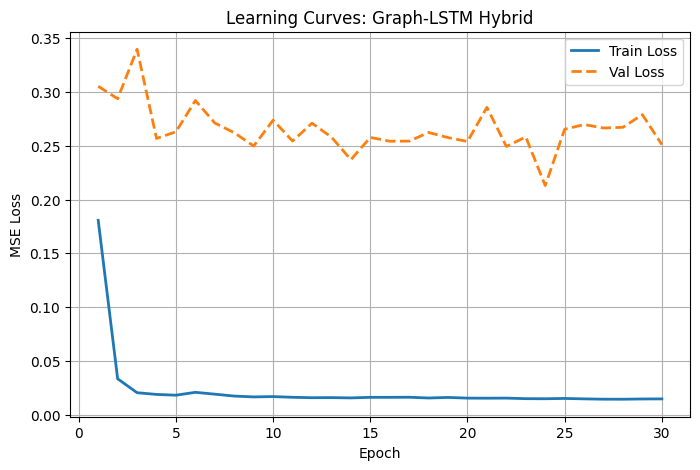


=== Training & Evaluating: Graph-LSTM Parametrized ===
Epoch 1/30 | Train Loss: 0.363240 | Val Loss:   0.399267
Epoch 5/30 | Train Loss: 0.035125 | Val Loss:   0.339381
Epoch 10/30 | Train Loss: 0.023844 | Val Loss:   0.345120
Epoch 15/30 | Train Loss: 0.021094 | Val Loss:   0.362569
Epoch 20/30 | Train Loss: 0.019654 | Val Loss:   0.371467
Epoch 25/30 | Train Loss: 0.019019 | Val Loss:   0.371553
Epoch 30/30 | Train Loss: 0.018594 | Val Loss:   0.375038
Test Loss: 0.571911
Graph-LSTM Parametrized Test Loss: 0.571911


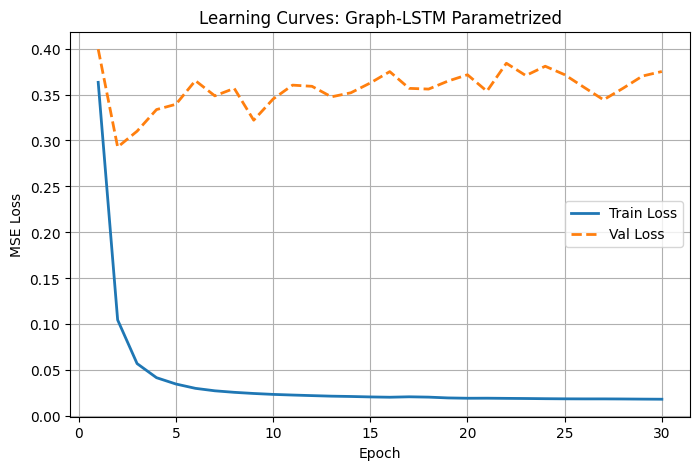


=== Training & Evaluating: Graph-xLSTM Hybrid ===
Epoch 1/30 | Train Loss: 0.184779 | Val Loss:   0.307816
Epoch 5/30 | Train Loss: 0.018929 | Val Loss:   0.281947
Epoch 10/30 | Train Loss: 0.017117 | Val Loss:   0.315383
Epoch 15/30 | Train Loss: 0.016129 | Val Loss:   0.289002
Epoch 20/30 | Train Loss: 0.015542 | Val Loss:   0.254559
Epoch 25/30 | Train Loss: 0.015582 | Val Loss:   0.253955
Epoch 30/30 | Train Loss: 0.014805 | Val Loss:   0.242609
Test Loss: 0.358289
Graph-xLSTM Hybrid Test Loss: 0.358289


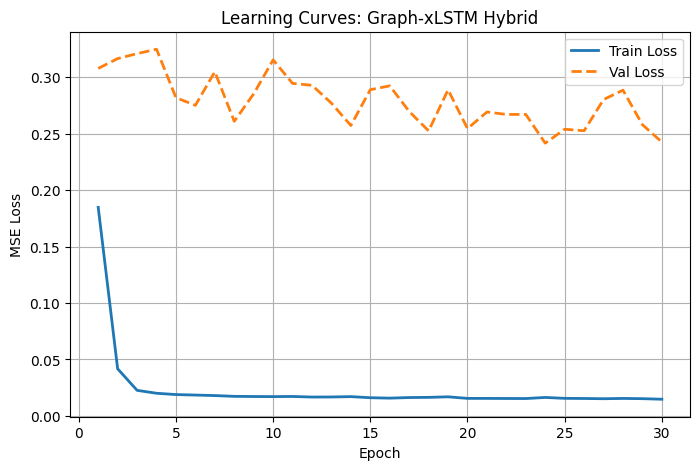


=== Training & Evaluating: Graph-xLSTM Parametrized ===
Epoch 1/30 | Train Loss: 0.379475 | Val Loss:   0.411775
Epoch 5/30 | Train Loss: 0.029347 | Val Loss:   0.287477
Epoch 10/30 | Train Loss: 0.021752 | Val Loss:   0.245767
Epoch 15/30 | Train Loss: 0.020193 | Val Loss:   0.188305
Epoch 20/30 | Train Loss: 0.019082 | Val Loss:   0.161638
Epoch 25/30 | Train Loss: 0.018365 | Val Loss:   0.137469
Epoch 30/30 | Train Loss: 0.017977 | Val Loss:   0.131215
Test Loss: 0.307464
Graph-xLSTM Parametrized Test Loss: 0.307464


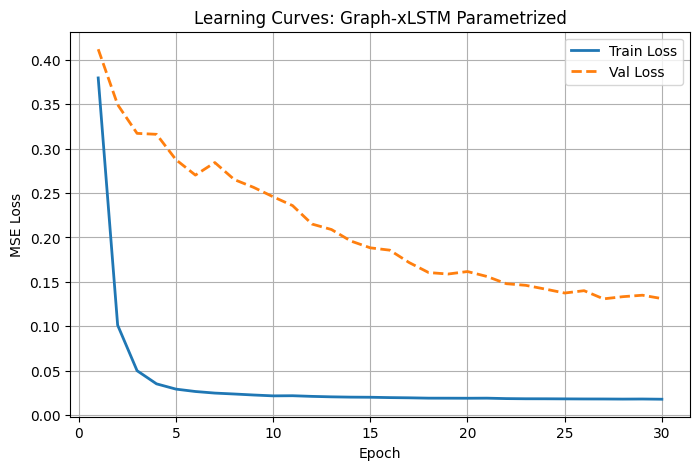

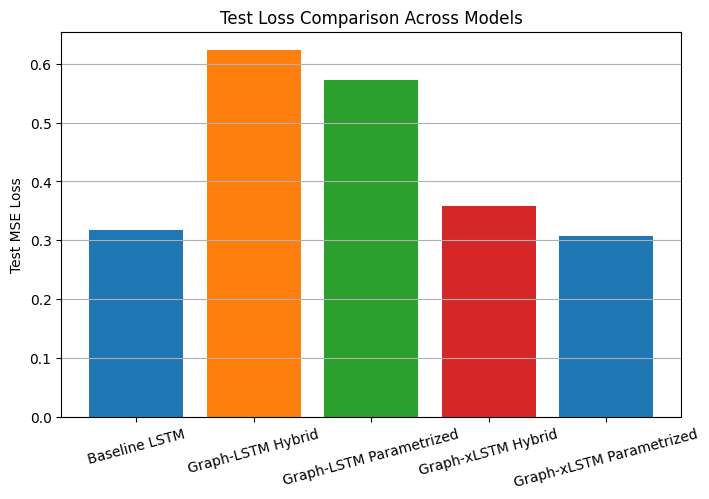

In [ ]:
models = {
    'Baseline LSTM': baseline_model,
    'Graph-LSTM Hybrid': graph_lstm_hybrid,
    'Graph-LSTM Parametrized': graph_lstm_param,
    'Graph-xLSTM Hybrid': graph_xlstm_hybrid,
    'Graph-xLSTM Parametrized': graph_xlstm_param
}

all_results = {}

for name, model in models.items():
    print(f"\n=== Training & Evaluating: {name} ===")
    results = train_and_evaluate_dataloader(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=30,
        lr=1e-2,
        device=device
    )
    all_results[name] = results

    # Print test loss
    print(f"{name} Test Loss: {results['test_loss']:.6f}")

    # Plot learning curves for this model
    epochs_range = range(1, len(results['train_losses']) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, results['train_losses'], label='Train Loss', linewidth=2)
    plt.plot(epochs_range, results['val_losses'],   '--', label='Val Loss',   linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Learning Curves: {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot their test losses side by side for comparison
model_names = list(all_results.keys())
test_losses = [all_results[n]['test_loss'] for n in model_names]

plt.figure(figsize=(8, 5))
plt.bar(model_names, test_losses, color=['C0','C1','C2','C3'])
plt.ylabel('Test MSE Loss')
plt.title('Test Loss Comparison Across Models')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


## Evaluation


=== Evaluating Model: Baseline LSTM ===
Baseline LSTM — Last-Train Step Loss: 0.0140


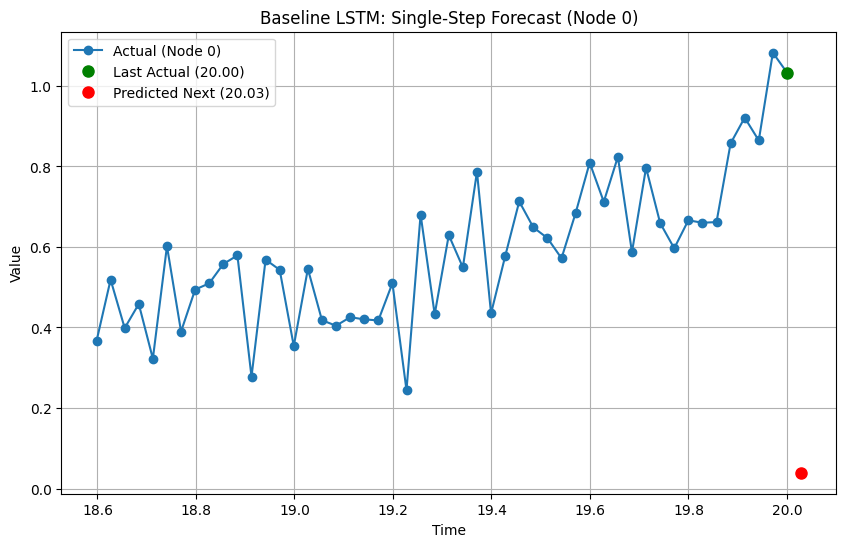

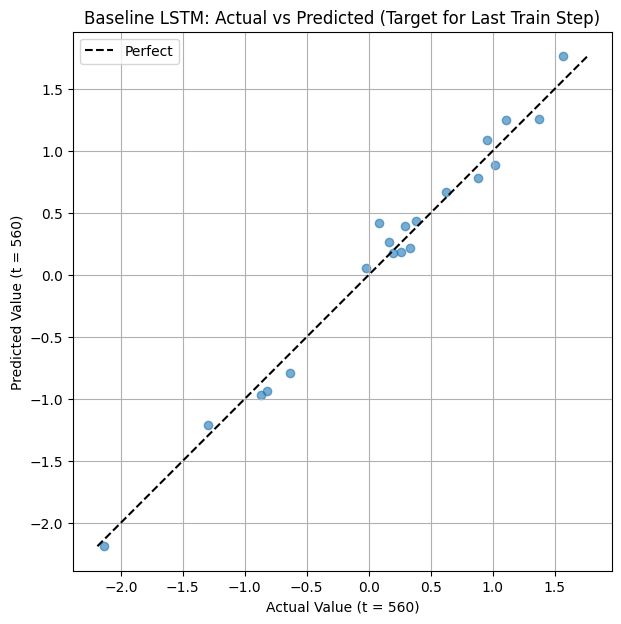


=== Evaluating Model: Graph-LSTM Hybrid ===
Graph-LSTM Hybrid — Last-Train Step Loss: 0.0245


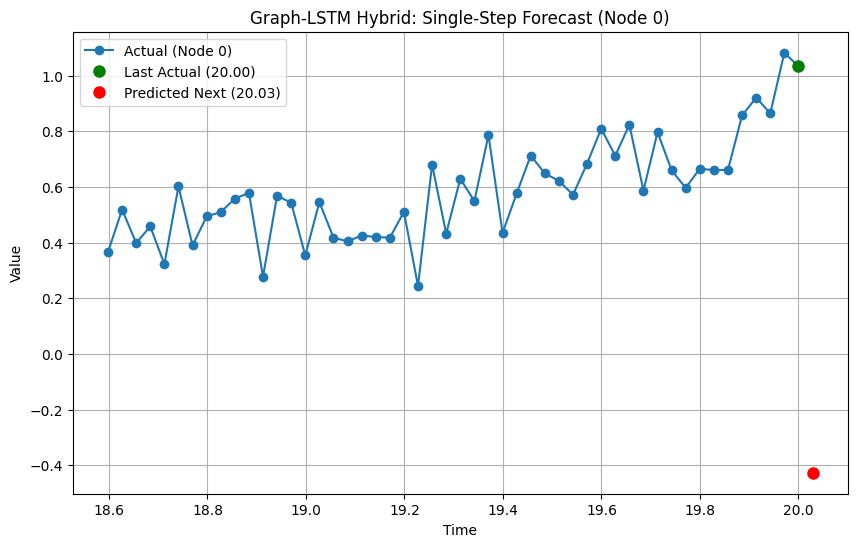

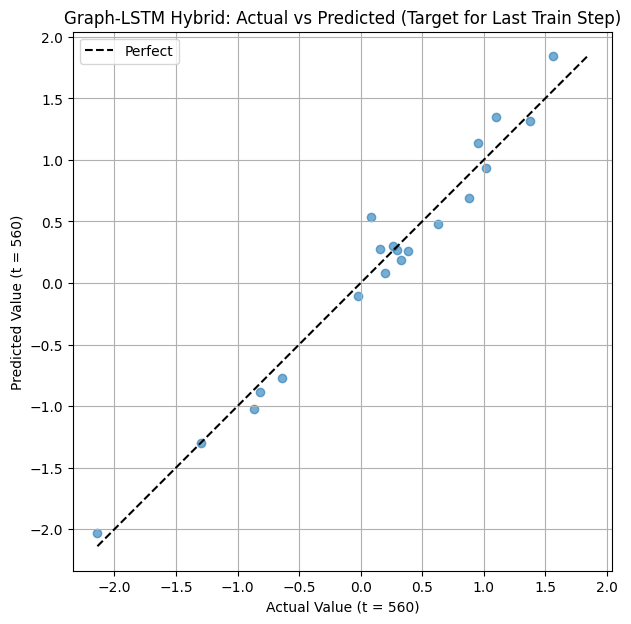


=== Evaluating Model: Parametrized LSTM ===
Parametrized LSTM — Last-Train Step Loss: 0.0364


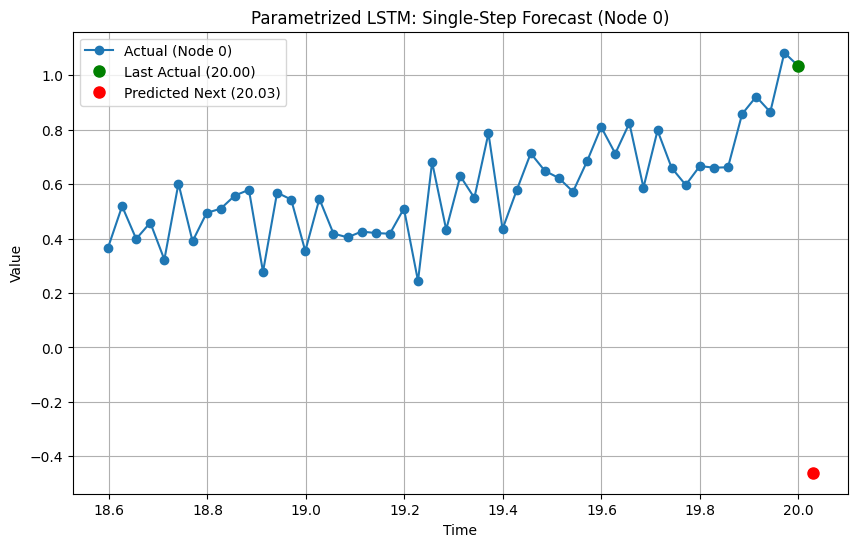

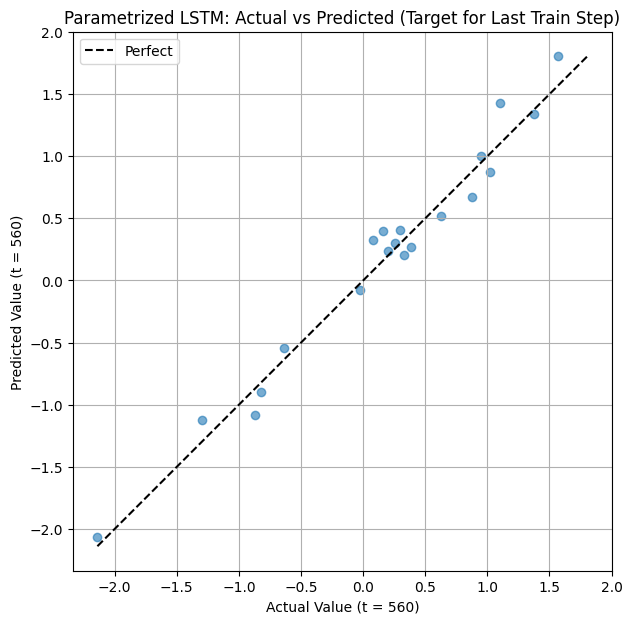


=== Evaluating Model: Graph-xLSTM Hybrid ===
Graph-xLSTM Hybrid — Last-Train Step Loss: 0.0178


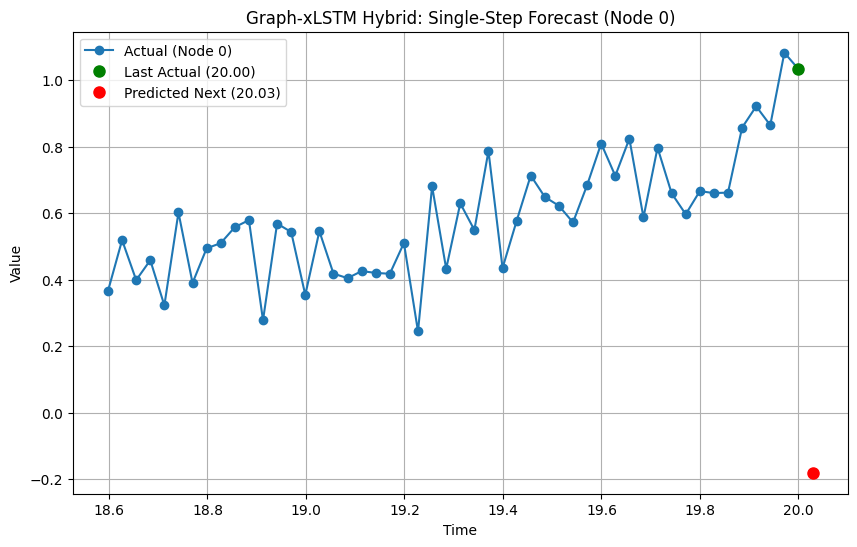

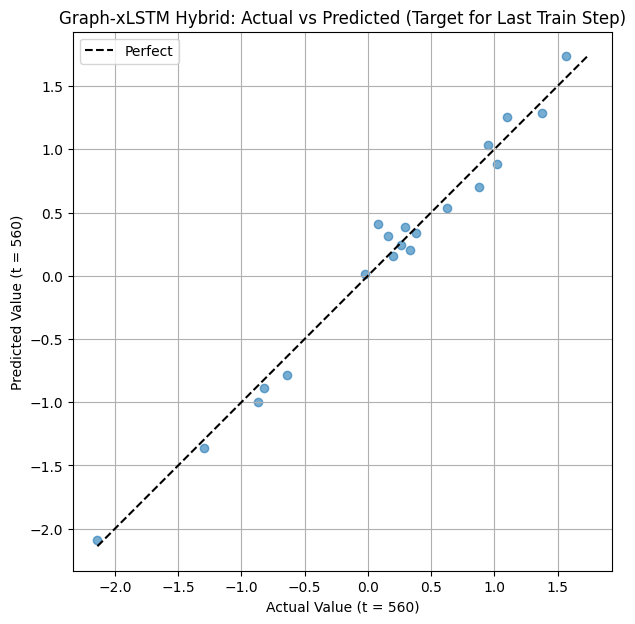

In [ ]:
_, T, N = data_torch.shape
train_T = int(0.8 * T)

# Define criterion
criterion = nn.MSELoss()

# Reconstruct train_x and train_y from the train_loader
# Initialize empty lists to store batches
all_train_x_batches = []
all_train_y_batches = []

# Iterate through the train_loader to collect all batches
for x_batch, y_batch in train_loader:
    all_train_x_batches.append(x_batch)
    all_train_y_batches.append(y_batch)

# 1) Define a dict of all models you want to evaluate
#    Each model must be on the same device as the data (e.g. CPU or GPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure models are defined and moved to device (done in previous cell, but good practice)
models = {
    'Baseline LSTM':          baseline_model.to(device),
    'Graph-LSTM Hybrid':      graph_lstm_hybrid.to(device),
    'Parametrized LSTM':      graph_lstm_param.to(device),
    'Graph-xLSTM Hybrid':     graph_xlstm_hybrid.to(device)
}

# 2) Loop over each model for evaluation
for name, model in models.items():
    print(f"\n=== Evaluating Model: {name} ===")

    model.eval()
    with torch.no_grad():
        # 2a) Last-training-step prediction & loss
        # Get the last window from the training time sequence
        # The last valid window START index for training is num_train_samples - 1
        last_train_window_start_idx = max(0, num_train_samples - 1)
        last_train_input = data_torch[:, last_train_window_start_idx : last_train_window_start_idx + window_size, :] # [1, window_size, N]
        last_train_target = data_torch[:, last_train_window_start_idx + window_size, :] # [1, N]

        # Ensure data is on the correct device
        last_train_input = last_train_input.to(device)
        last_train_target = last_train_target.to(device)


        pred_train_last = model(last_train_input)   # [1, N]
        loss_train_last = criterion(pred_train_last, last_train_target)
        print(f"{name} — Last-Train Step Loss: {loss_train_last.item():.4f}")

        # 2b) Next-step prediction after full sequence
        # The input for predicting the step AFTER the end of data_torch is the LAST window
        # in data_torch, which starts at index T - window_size.
        last_data_window_start_idx = max(0, T - window_size)
        input_for_next_step = data_torch[:, last_data_window_start_idx : last_data_window_start_idx + window_size, :] # [1, window_size, N]

        # Ensure data is on the correct device
        input_for_next_step = input_for_next_step.to(device)

        pred_next = model(input_for_next_step)                      # [1, N]


    # 3) Plot single-step forecast for a sample node
    node_to_plot = 0
    lookback = 50

    plt.figure(figsize=(10, 6))
    # Last 50 actual points from the original data NumPy array
    plt.plot(
        t[-lookback:],
        data[node_to_plot, -lookback:],
        marker='o', linestyle='-',
        label=f'Actual (Node {node_to_plot})'
    )
    # Last actual data point from the original data NumPy array
    last_time = t[-1]
    last_val = data[node_to_plot, -1]
    plt.plot(last_time, last_val, 'go', markersize=8,
             label=f'Last Actual ({last_time:.2f})')
    # Predicted next value
    if T > 1:
        dt = t[-1] - t[-2]
    else:
        dt = 1.0
    next_time = last_time + dt
    pred_val = pred_next[0, node_to_plot].item()
    plt.plot(next_time, pred_val, 'ro', markersize=8,
             label=f'Predicted Next ({next_time:.2f})')

    plt.title(f"{name}: Single-Step Forecast (Node {node_to_plot})")
    plt.xlabel("Time"); plt.ylabel("Value")
    plt.legend(); plt.grid(True)
    plt.show()

    # 4) Scatter: Actual vs Predicted for last training step, all nodes
    plt.figure(figsize=(7, 7))
    # The actual value at time step train_T (which was the target for the last training window)
    actual_last = data[:, train_T]  # [N]
    pred_last   = pred_train_last[0].cpu().numpy()     # [N]

    plt.scatter(actual_last, pred_last, alpha=0.6)
    plt.title(f"{name}: Actual vs Predicted (Target for Last Train Step)")
    plt.xlabel(f"Actual Value (t = {train_T})")
    plt.ylabel(f"Predicted Value (t = {train_T})")
    plt.grid(True)

    all_vals = np.concatenate((actual_last, pred_last))
    mn, mx = all_vals.min(), all_vals.max()
    plt.plot([mn, mx], [mn, mx], 'k--', label="Perfect")
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Scalability Analysis

Here we perform some numerical experiments to stress the scalability of our models and see how empirical results match the theoretical ones.

In [ ]:
# import torch, time, numpy as np, random, math
# from collections import defaultdict

# torch.manual_seed(0); random.seed(0)

# def make_series(F, S=64):
#     t = torch.linspace(0, 20, S, device=device)
#     phases, amps = 2*math.pi*torch.rand(F, device=device), 1.5+0.5*torch.rand(F, device=device)
#     sig = torch.sin(t[:,None] + phases)*amps + 0.1*torch.randn(S, F, device=device)
#     return sig.unsqueeze(0)        # [1,S,F]

# def knn_adj(F, k=10):
#     A = torch.rand(F, F)
#     A = (A+A.T)/2
#     idx = torch.topk(A, k=k+1, dim=1).indices
#     S  = torch.zeros_like(A)
#     for i in range(F):
#         S[i, idx[i]] = 1
#     S.fill_diagonal_(0)
#     deg = S.sum(1, keepdims=True)+1e-6
#     return (S/deg).cpu().numpy()

# def build_models(F, K=2, r=8):
#     S = knn_adj(F, k=10)
#     hybrid = Graph_xLSTM(num_nodes=F, hidden_dim=F, rank=r, A=S).to(device)
#     param  = Graph_xLSTM_Param(GSO=S, hidden_size=F, K=K).to(device)
#     hybrid.eval(); param.eval()
#     return hybrid, param

# def forward_time(model, x, repeats=50):
#     with torch.no_grad():
#         # warm-up
#         _ = model(x); torch.cuda.synchronize(device) if device=='cuda' else None
#         start = time.perf_counter()
#         for _ in range(repeats):
#             _ = model(x)
#         torch.cuda.synchronize(device) if device=='cuda' else None
#         return (time.perf_counter()-start)*1000/repeats   # ms

# F_list = [20, 40, 80, 160, 320, 640, 1000]
# results = defaultdict(list)
# for F in F_list:
#     x = make_series(F)
#     hybrid, param = build_models(F)
#     t_h = forward_time(hybrid, x)
#     t_p = forward_time(param,  x)

#     results['F'].append(F)
#     results['t_h'].append(t_h)
#     results['t_p'].append(t_p)
#     results['P_h'].append(sum(p.numel() for p in hybrid.parameters() if p.requires_grad))
#     results['P_p'].append(sum(p.numel() for p in param.parameters()  if p.requires_grad))

# print("   F | t_h (ms) | t_p (ms) | P_h | P_p")
# for i in range(len(F_list)):
#     print(f"{results['F'][i]:4d} | {results['t_h'][i]:8.3f} | {results['t_p'][i]:8.3f} | "
#           f"{results['P_h'][i]:5d} | {results['P_p'][i]:5d}")


   F | t_h (ms) | t_p (ms) | P_h | P_p
  20 |   20.178 |   30.490 |  2100 |   524
  40 |   15.043 |   69.018 |  5000 |  1824
  80 |   28.943 |   30.302 | 13200 |  6824
 160 |   14.435 |   42.596 | 39200 | 26424
 320 |   15.255 |   30.408 | 129600 | 104024
 640 |   14.976 |   29.760 | 464000 | 412824
1000 |   14.460 |   30.457 | 1085000 | 1005024


In [ ]:
class GraphLSTMCell(nn.Module):
    """
    LSTM cell where input-to-gate and hidden-to-gate transforms
    are polynomial graph filters of order K on graph shift operator GSO.
    Replaces dense W_x and W_h with Graph Shift Operator powers.
    """

    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        N = GSO.shape[0]
        self.hidden_size = hidden_size
        self.K = K

        # register the shift operator and its powers as buffers
        GSO_tensor = torch.tensor(GSO, dtype=torch.float32)
        self.register_buffer('GSO', GSO_tensor)
        powers = [torch.matrix_power(GSO_tensor, k) for k in range(K+1)]
        self.register_buffer('powers', torch.stack(powers, dim=0))  # shape [K+1, N, N]

        self.theta_x = nn.Parameter(torch.zeros(4, K+1))
        self.theta_h = nn.Parameter(torch.zeros(4, K+1))
        # rate biases (4 * hidden_size)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.theta_x, -0.1, 0.1)
        nn.init.uniform_(self.theta_h, -0.1, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x, hx):
        """
        x: [batch, N] node features at time t
        hx: (h, c) each [batch, hidden_size]
        returns: (h_next, c_next)
        """
        h, c = hx
        B, N = x.shape
        H = self.hidden_size
        # ensuring hidden_size matches number of nodes for pure graph filtering
        assert H == N, "hidden_size must equal num_nodes for GraphLSTM"

        filtered_x = torch.stack([x @ self.powers[k].T for k in range(self.K+1)], dim=0) # [K+1, B, N]
        filtered_h = torch.stack([h @ self.powers[k].T for k in range(self.K+1)], dim=0) # [K+1, B, N]

        gates_x = torch.einsum('gk,kbn->gbn', self.theta_x, filtered_x) # [4, B, N]
        gates_h = torch.einsum('gk,kbn->gbn', self.theta_h, filtered_h) # [4, B, N]

        # sum, add bias, reshape to [batch, 4*N]
        gates = gates_x + gates_h        # [4, B, N]
        gates = gates.permute(1, 0, 2)    # [B, 4, N]
        gates = gates.reshape(B, 4 * N)   # [B, 4*N]
        gates = gates + self.bias        # broadcast bias

        # split into the four gates
        i, f, g, o = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        # LSTM cell update
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class GraphLSTM(nn.Module):
    """
    Sequence model using the GraphLSTMCell.
    """
    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        # Check if GSO is a numpy array and convert to tensor
        if isinstance(GSO, np.ndarray):
            GSO = torch.tensor(GSO, dtype=torch.float32)

        self.cell = GraphLSTMCell(GSO, hidden_size, K)
        self.hidden_size = hidden_size

    def forward(self, x, hx=None):
        """
        x: [batch, seq, nodes]
        hx: optional initial (h0, c0), each [batch, hidden_size]
        returns: (out_seq, (h_n, c_n))
        """
        B, S_len, N = x.shape
        if hx is None:
            h = x.new_zeros(B, self.hidden_size).to(x.device)
            c = x.new_zeros(B, self.hidden_size).to(x.device)
        else:
            h, c = hx

        outputs = []

        for t in range(S_len):
            # Pass x at current time step [B, N] and hidden/cell states [B, H]
            h, c = self.cell(x[:, t, :], (h, c))
            outputs.append(h.unsqueeze(1))
        out_seq = torch.cat(outputs, dim=1)  # [B, S_len, N]
        return out_seq, (h, c)


class Graph_LSTM_Parametrized(nn.Module):
    """
    GraphLSTM-based next-step predictor.
    """
    def __init__(self, GSO, hidden_size, K=2):
        super().__init__()
        # Check if GSO is a numpy array and convert to tensor
        if isinstance(GSO, np.ndarray):
            GSO = torch.tensor(GSO, dtype=torch.float32)

        self.glstm = GraphLSTM(GSO, hidden_size, K)
        # Final readout: map hidden_size (== nodes) back to node predictions
        self.fc = nn.Linear(hidden_size, GSO.shape[0])

    def forward(self, x):
        """
        x: [batch, seq, nodes]
        returns: [batch, nodes]  next-step prediction
        """
        # Ensure input x is on the correct device before passing to glstm
        x = x.to(self.glstm.cell.powers.device) # Use device of a buffer for consistency
        out_seq, _ = self.glstm(x)       # [B, seq, N]
        last = out_seq[:, -1, :]         # [B, N]
        return self.fc(last)             # [B, N]

In [ ]:
import time, math
import pandas as pd
from collections import defaultdict

# reproducibility and device
torch.manual_seed(0);  random.seed(0)

# synthetic signal  (sequence length S = 64)
def make_series(F, S=64):
    t = torch.linspace(0, 20, S, device=device)
    phase = 2 * math.pi * torch.rand(F, device=device)
    amp   = 1.5 + 0.5 * torch.rand(F, device=device)
    sig   = torch.sin(t[:, None] + phase) * amp + 0.1 * torch.randn(S, F, device=device)
    return sig.unsqueeze(0)                                           # [1,S,F]

# 10-nearest neighbour row-normalised adjacency
def knn_adj(F, k=10):
    A = torch.rand(F, F)
    A = (A + A.t()) / 2
    idx = torch.topk(A, k=k + 1, dim=1).indices        # self + k neighbours
    S = torch.zeros_like(A)
    for i in range(F):
        S[i, idx[i]] = 1.
    S.fill_diagonal_(0)
    deg = S.sum(1, keepdims=True) + 1e-6
    return (S / deg).cpu().numpy()                     # numpy -> model

# Build all five models for a given F
def build_models(F, *, K=2, r=8):
    A = knn_adj(F)
    models = {
        'Baseline_LSTM'        : Baseline_LSTM(num_nodes=F, hidden_dim=F).to(device),
        'Graph_LSTM_Hybrid'    : Graph_LSTM(num_nodes=F, hidden_dim=F, GSO=A).to(device),
        'Graph_LSTM_Param'     : Graph_LSTM_Parametrized(GSO=A, hidden_size=F, K=K).to(device),
        'Graph_xLSTM_Hybrid'   : Graph_xLSTM(num_nodes=F, hidden_dim=F, rank=r, A=A).to(device),
        'Graph_xLSTM_Param'    : Graph_xLSTM_Param(GSO=A, hidden_size=F, K=K).to(device),  # shared-power impl
    }
    for m in models.values():
        m.eval()
    return models

def forward_time(model, x, repeats=50):
    with torch.no_grad():
        _ = model(x)                         # warm-up
        if device == 'cuda':
            torch.cuda.synchronize()
        start = time.perf_counter()
        for _ in range(repeats):
            _ = model(x)
        if device == 'cuda':
            torch.cuda.synchronize()
        dt_ms = (time.perf_counter() - start) * 1e3 / repeats
    return dt_ms

F_list = [20, 40, 80, 160, 320, 640, 1000]
records = []

for F in F_list:
    x_seq  = make_series(F)                  # [1,S,F]
    models = build_models(F)
    for name, mdl in models.items():
        t_ms = forward_time(mdl, x_seq)
        params = sum(p.numel() for p in mdl.parameters() if p.requires_grad)
        records.append({'F': F,
                        'model': name,
                        'time_ms': round(t_ms, 3),
                        'params': params})

df = pd.DataFrame(records)

print("\n=== Forward latency (ms) ===")
print(df.pivot(index='F', columns='model', values='time_ms'))

print("\n=== Parameter counts ===")
print(df.pivot(index='F', columns='model', values='params'))


/tmp/ipython-input-26-1562027831.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  GSO_tensor = torch.tensor(GSO, dtype=torch.float32)



=== Forward latency (ms) ===
model  Baseline_LSTM  Graph_LSTM_Hybrid  Graph_LSTM_Param  Graph_xLSTM_Hybrid  \
F                                                                               
20             0.235              0.308            31.375              13.423   
40             0.258              0.305            30.524              13.252   
80             0.247              0.306            36.479              20.017   
160            1.383              1.211            31.949              13.967   
320            1.340              1.416            31.324              13.621   
640            2.855              2.515            42.537              14.357   
1000           5.829              5.307            30.244              14.087   

model  Graph_xLSTM_Param  
F                         
20                28.854  
40                29.195  
80                28.997  
160               29.832  
320               30.207  
640               28.845  
1000              29.819